# Case 2 

**Imports**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.cluster.hierarchy as sch
from sklearn.mixture import GaussianMixture
import seaborn as sns

### Load and Explore the Data

In [8]:
# Load data
df = pd.read_csv("HR_data.csv")  # update with actual file path

# Quick overview
print(df.shape)
print(df.columns)
print(df.head())

# Optional: check for unique phases
if 'Phase' in df.columns:
	print(df['Phase'].value_counts())  # if 'Phase' column exists


(312, 68)
Index(['Unnamed: 0', 'HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min',
       'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', '

### Preprocess the Data

In [ ]:
# Drop obviously non-feature columns (e.g., participant ID, phase label)
meta_cols = ['participant_id', 'round', 'phase']  # update based on your actual columns
numeric_df = df.drop(columns=meta_cols, errors='ignore')

# Check which columns are not numeric
non_numeric_cols = numeric_df.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print("Non-numeric columns found and removed before scaling:", list(non_numeric_cols))
    numeric_df = numeric_df.drop(columns=non_numeric_cols)

# Drop rows with missing values (or handle imputation if you prefer)
features_clean = numeric_df.dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_clean)

# Optional: DataFrame version for later usage
X_scaled_df = pd.DataFrame(X_scaled, columns=features_clean.columns)


Non-numeric columns found and removed before scaling: ['Round', 'Phase', 'Cohort']


In [16]:
print(df.dtypes)  # See what each column's data type is

# Check if the 'round' column exists before accessing it
if 'round' in df.columns:
	print(df['round'].unique())  # Check if it says 'round_1', 'round_2' etc.
else:
	print("'round' column does not exist in the dataframe.")


Unnamed: 0        int64
HR_TD_Mean      float64
HR_TD_Median    float64
HR_TD_std       float64
HR_TD_Min       float64
                 ...   
nervous         float64
attentive       float64
afraid          float64
active          float64
determined      float64
Length: 68, dtype: object
'round' column does not exist in the dataframe.


### Dimensionality Reduction (PCA)

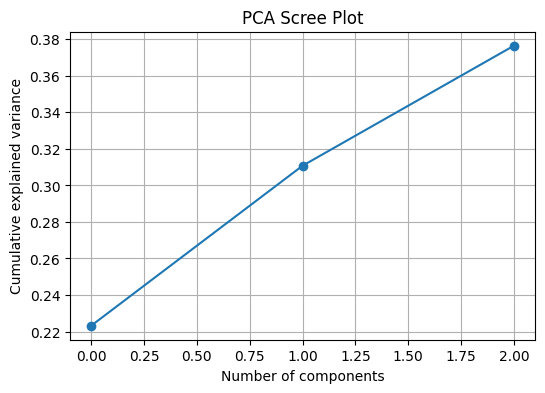

In [18]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Scree plot
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree Plot")
plt.grid(True)
plt.show()

# Optional: create a DataFrame with PCA components
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])


### Clustering Methods

#### K-Means

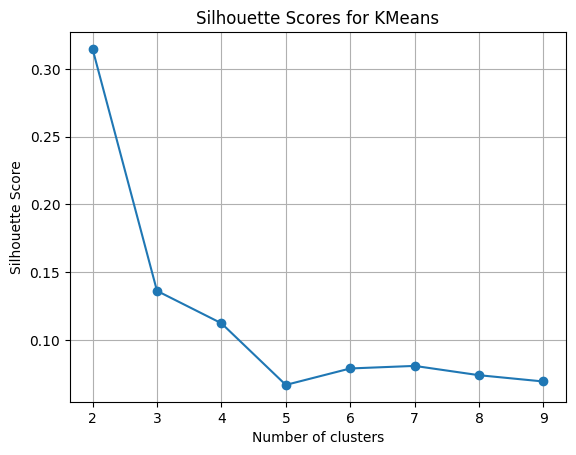

C:\Users\clara\AppData\Local\Temp\ipykernel_42624\1582965499.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean['kmeans_cluster'] = kmeans.fit_predict(X_scaled)


In [21]:
# Try different K
sil_scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

# Plot silhouette scores
plt.figure()
plt.plot(range(2, 10), sil_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for KMeans")
plt.grid(True)
plt.show()

# Final model
k_opt = 3  # set based on silhouette score or elbow
kmeans = KMeans(n_clusters=k_opt, random_state=42)
# Ensure the clustering labels are assigned to the correct DataFrame
features_clean['kmeans_cluster'] = kmeans.fit_predict(X_scaled)


#### Hierarchical Clustering

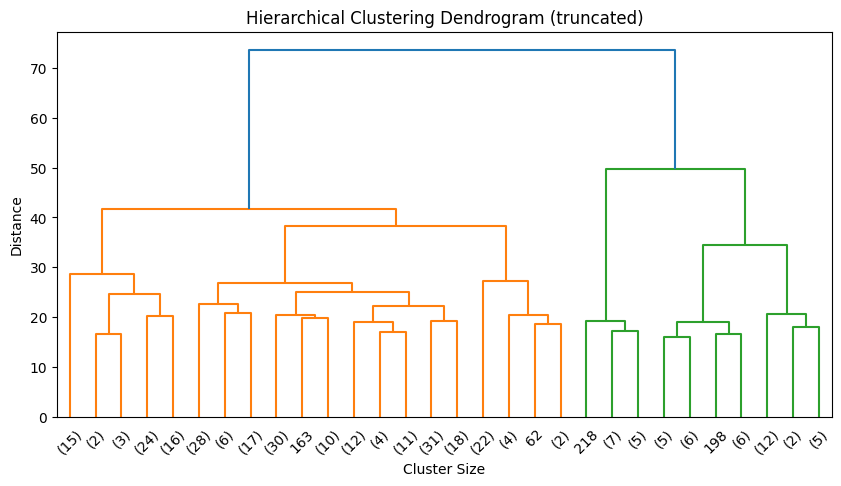

C:\Users\clara\AppData\Local\Temp\ipykernel_42624\4240671168.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean['hierarchical_cluster'] = fcluster(Z, t=3, criterion='maxclust')


In [24]:
# Linkage and dendrogram
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=30)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()

# Assign clusters
features_clean['hierarchical_cluster'] = fcluster(Z, t=3, criterion='maxclust')


#### Gaussian Mixture Models (GMM)

In [28]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
features_clean['gmm_cluster'] = gmm.fit_predict(X_scaled)

C:\Users\clara\AppData\Local\Temp\ipykernel_42624\4040413587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_clean['gmm_cluster'] = gmm.fit_predict(X_scaled)


### Cluster Evaluation + Visualization

#### Visualize PCA with Clusters

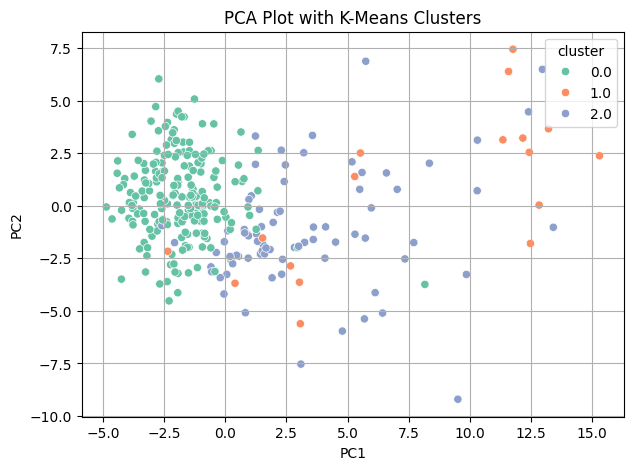

In [31]:
# Plot K-Means clusters
pca_df['cluster'] = features_clean['kmeans_cluster']

plt.figure(figsize=(7, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title("PCA Plot with K-Means Clusters")
plt.grid(True)
plt.show()


#### Cluster Profiles

cluster                        0           1           2
Unnamed: 0            150.385714  218.764706  155.912500
HR_TD_Mean             79.489367   83.031285   75.382565
HR_TD_Median           78.228405   82.720000   74.511750
HR_TD_std               7.224125    6.799085    4.693262
HR_TD_Min              68.731238   71.586471   68.604625
...                          ...         ...         ...
active                  2.676190    2.235294    2.312500
determined              2.995238    2.411765    2.812500
kmeans_cluster          0.000000    1.000000    2.000000
hierarchical_cluster    1.038095    2.235294    1.725000
gmm_cluster             0.000000    1.000000    1.975000

[68 rows x 3 columns]


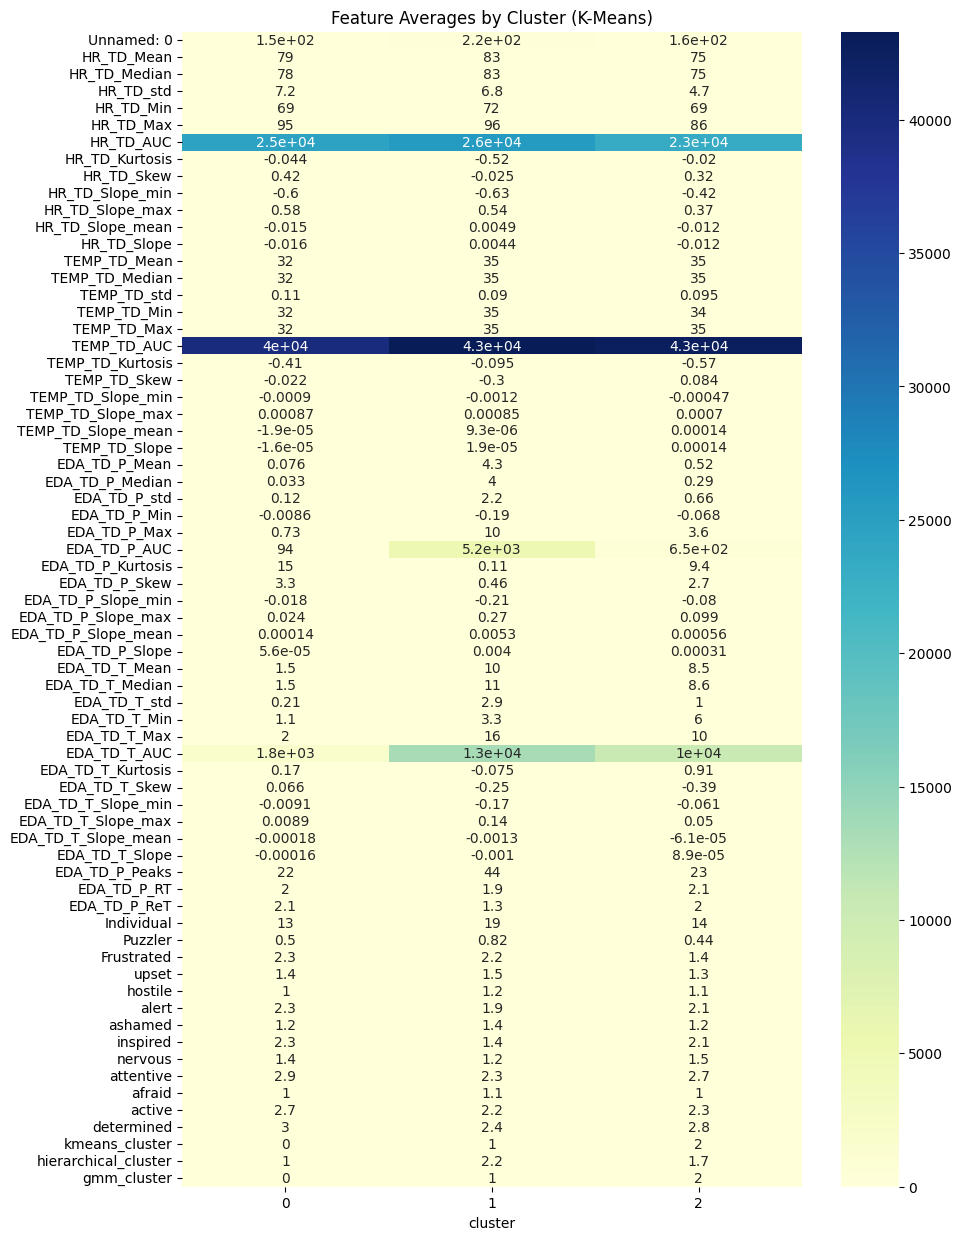

In [ ]:
# Calculate feature means per cluster
cluster_summary = features_clean.copy()
cluster_summary['cluster'] = features_clean['kmeans_cluster']
means = cluster_summary.groupby('cluster')[features_clean.columns].mean()
print(means.T)

# Optional: visualize a heatmap of cluster centers
plt.figure(figsize=(10, 15))
sns.heatmap(means.T, cmap="YlGnBu", annot=True)
plt.title("Feature Averages by Cluster (K-Means)")
plt.show()
